In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import uproot
import xgboost
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools
from collections import Counter
from sklearn.metrics import classification_report

In [2]:
def write_auc(config, roc_auc):
    file = write_path+'BDT_results.txt'
    with open(file, 'a+') as f:
        aucs = []
        for i in range(0, 4):
            aucs.append(roc_auc[i])
        auc_msg = ','.join(map(str, aucs))
        message = f'{config}; {auc_msg} \n'
        f.write(message)

In [3]:
def write_cm(config, cm_p, cm_e):
    file = write_path+'BDT_cm.txt'
    with open(file, 'a+') as f:
        cm_p_msg = ','.join(map(str, cm_p.flatten().tolist()))
        cm_e_msg = ','.join(map(str, cm_e.flatten().tolist()))
        message = f'{config}; {cm_p_msg}; {cm_e_msg} \n'
        f.write(message)

In [4]:
def plot_confusion_matrix(y_test, y_pred, classes, figname, w_test=None, normalise_by_col=False, normalise_by_row=False, cmap=plt.cm.Blues):
    if w_test is not None: cm = confusion_matrix(y_test, y_pred, sample_weight=w_test)
    else: cm = confusion_matrix(y_test, y_pred) 
    if normalise_by_col:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print ('Normalised efficiency confusion matrix')
    elif normalise_by_row:
        cm = cm.astype('float') / cm.sum(axis=0)[np.newaxis, :]
        print ('Normalised purity confusion matrix')
    else:
        print ('Non-normalised confusion matrix')

    print(cm)

    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.3f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment='center',
                 color='w' if cm[i, j] > thresh else 'k')

    plt.tight_layout(pad=1.4)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(figname)
    print ('Confusion matrix saved as {}'.format(figname))
    return cm

In [5]:
path = '/vols/cms/dw515/Offline/output/SM/masters_signal_vs_background_combined/'
write_path = '/home/hep/shc3117/MSci-Project-HiggsTauTau/shared/signal_background/'

In [6]:
vbfh_tree = uproot.open(path+'VBFH.root')['ntuple']
ztt_tree = uproot.open(path+'ZTT.root')['ntuple']
fakes_tree = uproot.open(path+'fakes.root')['ntuple']
ggh_tree = uproot.open(path+'ggH.root')['ntuple']

In [7]:
vbfh_tree.keys()

[b'genM',
 b'genpT',
 b'gen_nu_p_1',
 b'gen_nu_p_2',
 b'gen_nu_phi_1',
 b'gen_nu_phi_2',
 b'gen_nu_eta_1',
 b'gen_nu_eta_2',
 b'gen_vis_p_1',
 b'gen_vis_p_2',
 b'gen_vis_E_1',
 b'gen_vis_E_2',
 b'gen_vis_phi_1',
 b'gen_vis_phi_2',
 b'gen_vis_eta_1',
 b'gen_vis_eta_2',
 b'pt_2',
 b'pt_1',
 b'iso_1',
 b'met',
 b'wt_cp_sm',
 b'wt_cp_ps',
 b'wt_cp_mm',
 b'mva_dm_1',
 b'mva_dm_2',
 b'tau_decay_mode_2',
 b'tau_decay_mode_1',
 b'trg_singleelectron',
 b'trg_singlemuon',
 b'trg_doubletau',
 b'deepTauVsJets_medium_1',
 b'deepTauVsJets_medium_2',
 b'deepTauVsEle_vvloose_1',
 b'deepTauVsEle_vvloose_2',
 b'deepTauVsEle_tight_1',
 b'deepTauVsEle_tight_2',
 b'deepTauVsMu_vloose_1',
 b'deepTauVsMu_vloose_2',
 b'deepTauVsMu_tight_1',
 b'deepTauVsMu_tight_2',
 b'aco_angle_1',
 b'aco_angle_2',
 b'aco_angle_3',
 b'aco_angle_4',
 b'aco_angle_5',
 b'aco_angle_6',
 b'aco_angle_7',
 b'pv_angle',
 b'mass0',
 b'mass1',
 b'mass2',
 b'ip_sig_1',
 b'ip_sig_2',
 b'rand',
 b'tauFlag_1',
 b'tauFlag_2',
 b'gen_phitt',

In [8]:
variables = ['pt_1','pt_2', 'm_vis','svfit_mass','mjj','jpt_1','pt_tt','met','n_jets','pt_vis','iso_1','iso_2', 'wt']
selectors = ['rand', 'wt_cp_sm', 'deepTauVsJets_medium_1', 'deepTauVsJets_medium_2', 'trg_doubletau', 'os']

In [9]:
vbfh = vbfh_tree.pandas.df(variables+selectors)
ztt = ztt_tree.pandas.df(variables+selectors)
fakes = fakes_tree.pandas.df(variables+selectors)
ggh = ggh_tree.pandas.df(variables+selectors)

In [10]:
vbfh = vbfh[vbfh['deepTauVsJets_medium_1'] & vbfh['deepTauVsJets_medium_2'] & vbfh['trg_doubletau'] & vbfh['os']]
ztt = ztt[ztt['deepTauVsJets_medium_1'] & ztt['deepTauVsJets_medium_2'] & ztt['trg_doubletau'] & ztt['os']]
fakes = fakes[fakes['deepTauVsJets_medium_1'] & fakes['deepTauVsJets_medium_2'] & fakes['trg_doubletau'] & (fakes['os']==0)]
ggh = ggh[ggh['deepTauVsJets_medium_1'] & ggh['deepTauVsJets_medium_2'] & ggh['trg_doubletau'] & ggh['os']]

In [11]:
vbfh_sm = vbfh[(vbfh["rand"] < vbfh["wt_cp_sm"]/2)]
ggh_sm = ggh[(ggh["rand"] < ggh["wt_cp_sm"]/2)]

In [12]:
vbfh_sm.loc[:, 'y'] = np.zeros(vbfh_sm.shape[0])
ztt.loc[:, 'y'] = np.ones(ztt.shape[0])
fakes.loc[:, 'y'] = np.full((fakes.shape[0],),2.)
ggh_sm.loc[:, 'y'] = np.full((ggh_sm.shape[0],),3.)

/home/hep/shc3117/anaconda3/envs/msci/lib/python3.8/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/home/hep/shc3117/anaconda3/envs/msci/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [13]:
vbfh_sm = vbfh_sm[(vbfh_sm != -9999).all(1)]
ztt = ztt[(ztt != -9999).all(1)]
fakes = fakes[(fakes != -9999).all(1)]
ggh_sm = ggh_sm[(ggh_sm != -9999).all(1)]

In [14]:
ggh_sm.wt.describe()

count    116239.000000
mean          0.860433
std           0.326771
min          -1.306711
25%           0.729219
50%           0.899644
75%           1.043154
max          20.150797
Name: wt, dtype: float64

In [15]:
df = pd.concat([vbfh_sm, ztt, fakes, ggh_sm]).reset_index(drop=True)

In [16]:
df = df[(df >= 0).all(1)]

In [19]:
print(sorted(Counter(df.y).items()))

[(0.0, 363422), (1.0, 21978), (2.0, 36420), (3.0, 115716)]


# base case

In [82]:
df_1 = df.drop(selectors+['iso_1', 'iso_2'], axis=1)

In [83]:
# xgb_params = {
#     "objective": "multi:softmax",
#     "max_depth": 6,
#     "num_classes": 4,
# }
xgb_params = {
    "objective": "multi:softprob",
    "max_depth": 3,
    "learning_rate": 0.05,
    "silent": 1,
    "n_estimators": 1000,
    "subsample": 0.9,
    "seed": 123451,
}

xgb_clf = xgboost.XGBClassifier(**xgb_params)
# xgb_clf = xgboost.XGBClassifier()


In [84]:
df_1.drop(['y', 'wt'], axis=1).columns

Index(['pt_1', 'pt_2', 'm_vis', 'svfit_mass', 'mjj', 'jpt_1', 'pt_tt', 'met',
       'n_jets', 'pt_vis'],
      dtype='object')

In [85]:
X = df_1.drop(['y', 'wt'], axis=1).to_numpy()
y = df_1.y.astype(int)
w = df_1.wt
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X, y, w, test_size=0.2, random_state=1, stratify=df_1.y)

In [87]:
eval_set = [(X_train, y_train), (X_test, y_test)]
xgb_clf.fit(X_train, y_train, sample_weight=w_train, verbose=2, early_stopping_rounds=1000, eval_set=eval_set, eval_metric = "mlogloss")
# xgb_clf.fit(X_train, y_train, sample_weight=w_train, verbose=2, eval_metric="mlogloss")

/home/hep/shc3117/anaconda3/envs/msci/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:11:49] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-mlogloss:1.33292	validation_1-mlogloss:1.33303
[2]	validation_0-mlogloss:1.24063	validation_1-mlogloss:1.24081
[4]	validation_0-mlogloss:1.16305	validation_1-mlogloss:1.16342
[6]	validation_0-mlogloss:1.09729	validation_1-mlogloss:1.09771
[8]	validation_0-mlogloss:1.04061	validation_1-mlogloss:1.04120
[10]	validation_0-mlogloss:0.99158	validation_1-mlogloss:0.99226
[12]	validation_0-mlogloss:0.94878	validation_1-mlogloss:0.94960
[14]	validation_0-mlogloss:0.91130	validation_1-mlogloss:0.91226
[16]	validation_0-mlogloss:0.87842	validation_1-mlogloss:0.87945
[18]	validation_0-mlogloss:0.84935	validation_1-mlogloss:0.85049
[20]	validation_0-mlogloss:0.

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=16, num_parallel_tree=1,
              objective='multi:softprob', random_state=123451, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, seed=123451, silent=1,
              subsample=0.9, tree_method='exact', validate_parameters=1,
              verbosity=None)

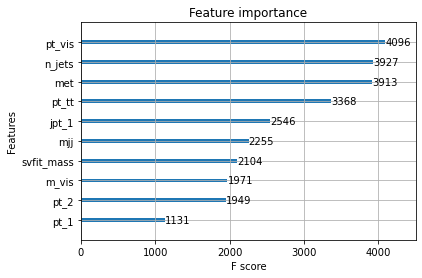

In [54]:
xgboost.plot_importance(xgb_clf).set_yticklabels(df_1.drop(['y','wt'], axis=1).columns)
plt.savefig('./signal_background/feature_importance_weight.png')
plt.show()

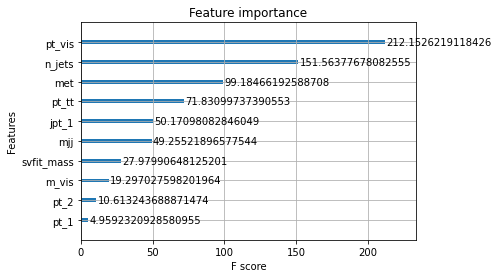

In [55]:
xgboost.plot_importance(xgb_clf, importance_type='gain').set_yticklabels(df_1.drop(['y','wt'], axis=1).columns)
plt.savefig('./signal_background/feature_importance_gain.png')
plt.show()

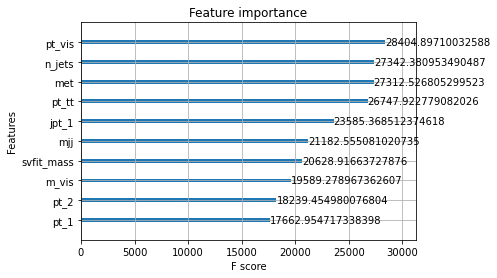

In [20]:
xgboost.plot_importance(xgb_clf, importance_type='cover').set_yticklabels(df_1.drop(['y','wt'], axis=1).columns)
# plt.savefig('./signal_background/eda/feature_importance.png')
plt.show()

In [88]:
y_pred = xgb_clf.predict_proba(X_test)

In [22]:
roc_auc_score(y_test, y_pred, multi_class='ovr')

0.8950004636213132

In [23]:
roc_auc_score(y_test, y_pred, multi_class='ovo')

0.8668710464845789

In [89]:
onehot=label_binarize(y_test,classes=[0,1,2,3])
fpr=dict()
tpr=dict()
thresh = dict()
roc_auc=dict()
for i in range(4):
    fpr[i], tpr[i], thresh[i] = roc_curve(onehot[:,i], y_pred[:,i])#,None,w_test)
    roc_auc[i] = auc(fpr[i], tpr[i])#,reorder=True)

In [38]:
write_auc('base', roc_auc)

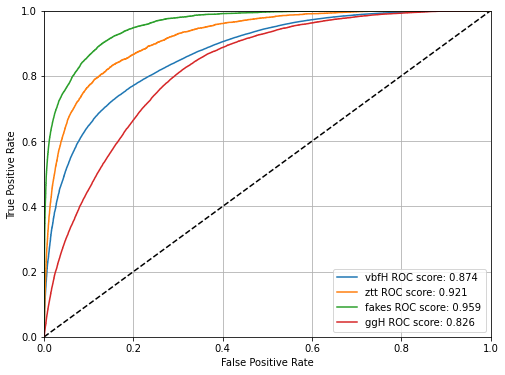

In [90]:
classes = ['vbfH', 'ztt', 'fakes', 'ggH']
fig, ax = plt.subplots(figsize=(8,6))
def plot_roc_curve(fpr, tpr, auc, i):
    ax.plot(fpr, tpr, label=f'{classes[i]} ROC score: {auc:.3f}')
    ax.set(xlabel='False Positive Rate', ylabel='True Positive Rate')
#     ax.text(0.6, 0.3, 'ROC AUC Score: {:.3f}'.format(auc),
#             bbox=dict(boxstyle='square,pad=0.3', fc='white', ec='k'))
    plt.legend()
lims = [np.min([ax.get_xlim(), ax.get_ylim()]), np.max([ax.get_xlim(), ax.get_ylim()])]
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.plot(lims, lims, 'k--')
ax.grid()
for i in range(len(fpr)):
    plot_roc_curve(fpr[i],tpr[i],roc_auc[i], i)
# plot_roc_curve(fpr[1],tpr[1],roc_auc[1], 1)
# plot_roc_curve(fpr[2],tpr[2],roc_auc[2], 2)
# plot_roc_curve(fpr[3],tpr[3],roc_auc[3], 3)
# plt.savefig('/signal_background/eda/roc_curves.png')

In [91]:
cr = classification_report(onehot, y_pred>0.5, output_dict=True, target_names=classes)
pd.DataFrame(cr).transpose()

/home/hep/shc3117/anaconda3/envs/msci/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
vbfH,0.809784,0.929215,0.865398,72685.0
ztt,0.769231,0.054595,0.101954,4396.0
fakes,0.780851,0.612438,0.686466,7284.0
ggH,0.622236,0.310029,0.413855,23143.0
micro avg,0.786601,0.738699,0.761897,107508.0
macro avg,0.745525,0.476569,0.516918,107508.0
weighted avg,0.765792,0.738699,0.724855,107508.0
samples avg,0.738699,0.738699,0.738699,107508.0


Normalised purity confusion matrix
[[0.81253555 0.25660074 0.06350822 0.26391048]
 [0.00751969 0.4263656  0.04129765 0.01396844]
 [0.01275561 0.16280881 0.83134216 0.13868123]
 [0.16718915 0.15422485 0.06385198 0.58343985]]
Confusion matrix saved as /home/hep/shc3117/MSci-Project-HiggsTauTau/shared/signal_background/purity.png
Normalised efficiency confusion matrix
[[0.94817015 0.00130729 0.00537901 0.04514356]
 [0.52125248 0.12903265 0.2077792  0.14193567]
 [0.13550247 0.0075508  0.64099396 0.21595277]
 [0.64796566 0.00260956 0.01796166 0.33146312]]
Confusion matrix saved as /home/hep/shc3117/MSci-Project-HiggsTauTau/shared/signal_background/efficiency.png


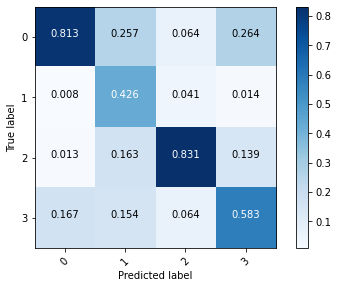

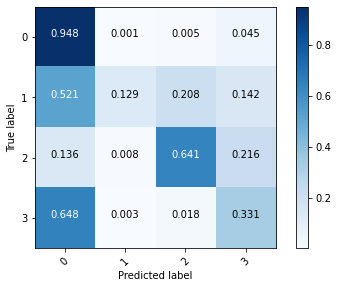

In [61]:
predict=xgb_clf.predict(X_test)
cm_p=plot_confusion_matrix(y_test, predict, [0,1,2,3],
                    normalise_by_row=True, w_test=w_test, figname=f'{write_path}purity.png')
cm_e=plot_confusion_matrix(y_test, predict, [0,1,2,3],
                    normalise_by_col=True, w_test=w_test, figname=f'{write_path}efficiency.png')

In [84]:
write_cm('base', cm_p, cm_e)

## adding iso_1/ iso_2

In [93]:
df_2 = df.drop(selectors, axis=1)

In [94]:
# xgb_params = {
#     "objective": "multi:softmax",
#     "max_depth": 6,
#     "num_classes": 4,
# }
xgb_params = {
    "objective": "multi:softprob",
    "max_depth": 3,
    "learning_rate": 0.05,
    "silent": 1,
    "n_estimators": 1000,
    "subsample": 0.9,
    "seed": 123451,
}

xgb_clf_2 = xgboost.XGBClassifier(**xgb_params)

In [95]:
X = df_2.drop(['y', 'wt'], axis=1).to_numpy()
y = df_2.y.astype(int)
w = df_2.wt
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X, y, w, test_size=0.2, random_state=1, stratify=df_1.y)

In [96]:
eval_set = [(X_train, y_train), (X_test, y_test)]
xgb_clf_2.fit(X_train, y_train, sample_weight=w_train, verbose=2, early_stopping_rounds=1000, eval_set=eval_set, eval_metric = "mlogloss")
# xgb_clf.fit(X_train, y_train, sample_weight=w_train, verbose=2, eval_metric="mlogloss")

/home/hep/shc3117/anaconda3/envs/msci/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:39:59] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-mlogloss:1.33272	validation_1-mlogloss:1.33291
[2]	validation_0-mlogloss:1.24013	validation_1-mlogloss:1.24035
[4]	validation_0-mlogloss:1.16226	validation_1-mlogloss:1.16262
[6]	validation_0-mlogloss:1.09610	validation_1-mlogloss:1.09654
[8]	validation_0-mlogloss:1.03904	validation_1-mlogloss:1.03970
[10]	validation_0-mlogloss:0.98961	validation_1-mlogloss:0.99034
[12]	validation_0-mlogloss:0.94646	validation_1-mlogloss:0.94732
[14]	validation_0-mlogloss:0.90870	validation_1-mlogloss:0.90960
[16]	validation_0-mlogloss:0.87545	validation_1-mlogloss:0.87641
[18]	validation_0-mlogloss:0.84598	validation_1-mlogloss:0.84708
[20]	validation_0-mlogloss:0.

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=16, num_parallel_tree=1,
              objective='multi:softprob', random_state=123451, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, seed=123451, silent=1,
              subsample=0.9, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [97]:
y_pred = xgb_clf_2.predict_proba(X_test)

In [98]:
onehot=label_binarize(y_test,classes=[0,1,2,3])
fpr=dict()
tpr=dict()
thresh = dict()
roc_auc=dict()
for i in range(4):
    fpr[i], tpr[i], thresh[i] = roc_curve(onehot[:,i], y_pred[:,i])#,None,w_test)
    roc_auc[i] = auc(fpr[i], tpr[i])#,reorder=True)

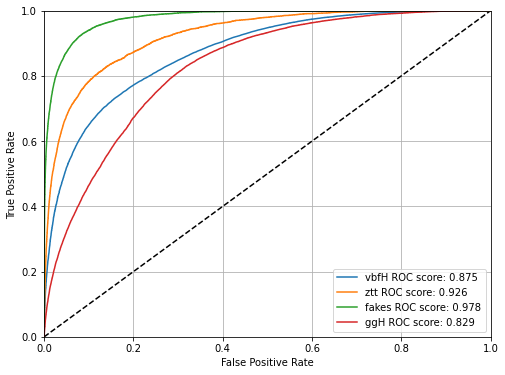

In [99]:
classes = ['vbfH', 'ztt', 'fakes', 'ggH']
fig, ax = plt.subplots(figsize=(8,6))
def plot_roc_curve(fpr, tpr, auc, i):
    ax.plot(fpr, tpr, label=f'{classes[i]} ROC score: {auc:.3f}')
    ax.set(xlabel='False Positive Rate', ylabel='True Positive Rate')
#     ax.text(0.6, 0.3, 'ROC AUC Score: {:.3f}'.format(auc),
#             bbox=dict(boxstyle='square,pad=0.3', fc='white', ec='k'))
    plt.legend()
lims = [np.min([ax.get_xlim(), ax.get_ylim()]), np.max([ax.get_xlim(), ax.get_ylim()])]
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.plot(lims, lims, 'k--')
ax.grid()
for i in range(len(fpr)):
    plot_roc_curve(fpr[i],tpr[i],roc_auc[i], i)
# plot_roc_curve(fpr[1],tpr[1],roc_auc[1], 1)
# plot_roc_curve(fpr[2],tpr[2],roc_auc[2], 2)
# plot_roc_curve(fpr[3],tpr[3],roc_auc[3], 3)
plt.savefig('./signal_background/roc_curves_with_iso.png')

In [100]:
cr = classification_report(onehot, y_pred>0.5, output_dict=True, target_names=classes)
pd.DataFrame(cr).transpose()

/home/hep/shc3117/anaconda3/envs/msci/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
vbfH,0.809345,0.932242,0.866457,72685.0
ztt,0.837945,0.096451,0.172991,4396.0
fakes,0.790291,0.712932,0.749621,7284.0
ggH,0.647483,0.306745,0.416278,23143.0
micro avg,0.790818,0.748558,0.769108,107508.0
macro avg,0.771266,0.512093,0.551337,107508.0
weighted avg,0.774380,0.748558,0.733276,107508.0
samples avg,0.748558,0.748558,0.748558,107508.0


In [98]:
write_auc('with_iso', roc_auc)

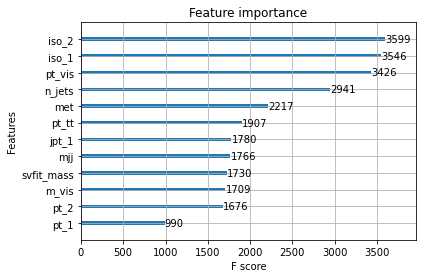

In [55]:
xgboost.plot_importance(xgb_clf_2).set_yticklabels(df_2.drop(['y','wt'], axis=1).columns)
plt.savefig('./signal_background/feature_importance_with_iso_weight.png')
plt.show()

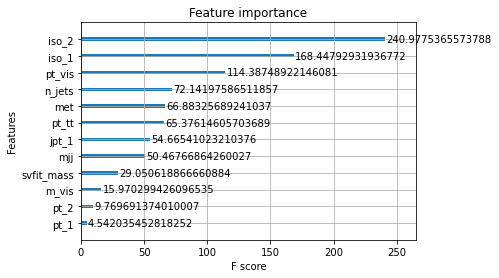

In [54]:
xgboost.plot_importance(xgb_clf_2, importance_type='gain').set_yticklabels(df_2.drop(['y','wt'], axis=1).columns)
plt.savefig('./signal_background/feature_importance_with_iso_gain.png')
plt.show()

Normalised purity confusion matrix
[[0.81458783 0.24535    0.06262646 0.27997621]
 [0.00759911 0.46798744 0.02533541 0.01518672]
 [0.01036009 0.15480273 0.81788987 0.08792444]
 [0.16745297 0.13185983 0.09414826 0.61691262]]
Confusion matrix saved as /home/hep/shc3117/MSci-Project-HiggsTauTau/shared/signal_background//purity_with_iso.png
Normalised efficiency confusion matrix
[[0.94862055 0.00160144 0.00636618 0.04341183]
 [0.52568074 0.18145255 0.15298675 0.13987996]
 [0.10982976 0.00919824 0.75686436 0.12410763]
 [0.64766055 0.00285849 0.03178583 0.31769513]]
Confusion matrix saved as /home/hep/shc3117/MSci-Project-HiggsTauTau/shared/signal_background//efficiency_with_iso.png


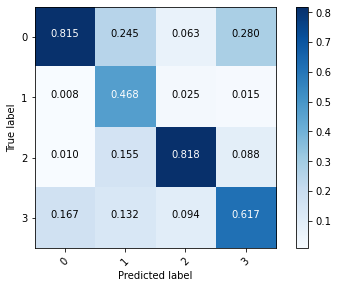

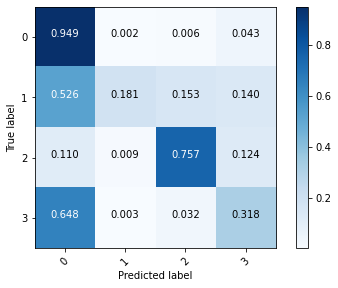

In [99]:
predict=xgb_clf_2.predict(X_test)
cm_p = plot_confusion_matrix(y_test, predict, [0,1,2,3],
                    normalise_by_row=True, w_test=w_test, figname=f'{write_path}/purity_with_iso.png')
cm_e = plot_confusion_matrix(y_test, predict, [0,1,2,3],
                    normalise_by_col=True, w_test=w_test, figname=f'{write_path}/efficiency_with_iso.png')

In [100]:
write_cm('with_iso', cm_p, cm_e)

## adding aco_angle_1

In [124]:
variables = ['pt_1','pt_2', 'm_vis','svfit_mass','mjj','jpt_1','pt_tt','met','n_jets','pt_vis','iso_1','iso_2', 'wt']
# extra_variables = [
#     'aco_angle_1', 'aco_angle_2', 'aco_angle_3', 'aco_angle_4', 'aco_angle_5', 'aco_angle_6', 'aco_angle_7', 'pv_angle',
    
# ]
extra_variables = [
    'aco_angle_1',
]
selectors = ['rand', 'wt_cp_sm', 'deepTauVsJets_medium_1', 'deepTauVsJets_medium_2', 'trg_doubletau', 'os']

In [125]:
vbfh = vbfh_tree.pandas.df(variables+selectors+extra_variables)
ztt = ztt_tree.pandas.df(variables+selectors+extra_variables)
fakes = fakes_tree.pandas.df(variables+selectors+extra_variables)
ggh = ggh_tree.pandas.df(variables+selectors+extra_variables)

In [126]:
vbfh = vbfh[vbfh['deepTauVsJets_medium_1'] & vbfh['deepTauVsJets_medium_2'] & vbfh['trg_doubletau'] & vbfh['os']]
ztt = ztt[ztt['deepTauVsJets_medium_1'] & ztt['deepTauVsJets_medium_2'] & ztt['trg_doubletau'] & ztt['os']]
fakes = fakes[fakes['deepTauVsJets_medium_1'] & fakes['deepTauVsJets_medium_2'] & fakes['trg_doubletau'] & (fakes['os']==0)]
ggh = ggh[ggh['deepTauVsJets_medium_1'] & ggh['deepTauVsJets_medium_2'] & ggh['trg_doubletau'] & ggh['os']]

In [127]:
vbfh_sm = vbfh[(vbfh["rand"] < vbfh["wt_cp_sm"]/2)]
ggh_sm = ggh[(ggh["rand"] < ggh["wt_cp_sm"]/2)]

In [128]:
vbfh_sm.loc[:, 'y'] = np.zeros(vbfh_sm.shape[0])
ztt.loc[:, 'y'] = np.ones(ztt.shape[0])
fakes.loc[:, 'y'] = np.full((fakes.shape[0],),2.)
ggh_sm.loc[:, 'y'] = np.full((ggh_sm.shape[0],),3.)

/home/hep/shc3117/anaconda3/envs/msci/lib/python3.8/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/home/hep/shc3117/anaconda3/envs/msci/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [129]:
vbfh_sm = vbfh_sm[(vbfh_sm != -9999).all(1)]
ztt = ztt[(ztt != -9999).all(1)]
fakes = fakes[(fakes != -9999).all(1)]
ggh_sm = ggh_sm[(ggh_sm != -9999).all(1)]

In [101]:
df = pd.concat([vbfh_sm, ztt, fakes, ggh_sm]).reset_index(drop=True)

In [102]:
df = df[(df >= 0).all(1)]

In [108]:
# xgb_params = {
#     "objective": "multi:softmax",
#     "max_depth": 6,
#     "num_classes": 4,
# }
xgb_params = {
    "objective": "multi:softprob",
    "max_depth": 3,
    "learning_rate": 0.05,
    "silent": 1,
    "n_estimators": 1000,
    "subsample": 0.9,
    "seed": 123451,
}

xgb_clf_3 = xgboost.XGBClassifier(**xgb_params)

In [103]:
df_1 = df.drop(selectors, axis=1)

In [104]:
df_1.drop(['y', 'wt'], axis=1).columns

Index(['pt_1', 'pt_2', 'm_vis', 'svfit_mass', 'mjj', 'jpt_1', 'pt_tt', 'met',
       'n_jets', 'pt_vis', 'iso_1', 'iso_2'],
      dtype='object')

In [105]:
X = df_1.drop(['y', 'wt'], axis=1).to_numpy()
y = df_1.y.astype(int)
w = df_1.wt
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X, y, w, test_size=0.2, random_state=1, stratify=df_1.y)

In [109]:
eval_set = [(X_train, y_train), (X_test, y_test)]
xgb_clf_3.fit(X_train, y_train, sample_weight=w_train, verbose=2, early_stopping_rounds=1000, eval_set=eval_set, eval_metric = "mlogloss")
# xgb_clf.fit(X_train, y_train, sample_weight=w_train, verbose=2, eval_metric="mlogloss")

/home/hep/shc3117/anaconda3/envs/msci/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:50:55] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-mlogloss:1.33272	validation_1-mlogloss:1.33291
[2]	validation_0-mlogloss:1.24013	validation_1-mlogloss:1.24035
[4]	validation_0-mlogloss:1.16226	validation_1-mlogloss:1.16262
[6]	validation_0-mlogloss:1.09610	validation_1-mlogloss:1.09654
[8]	validation_0-mlogloss:1.03904	validation_1-mlogloss:1.03970
[10]	validation_0-mlogloss:0.98961	validation_1-mlogloss:0.99034
[12]	validation_0-mlogloss:0.94646	validation_1-mlogloss:0.94732
[14]	validation_0-mlogloss:0.90870	validation_1-mlogloss:0.90960
[16]	validation_0-mlogloss:0.87545	validation_1-mlogloss:0.87641
[18]	validation_0-mlogloss:0.84598	validation_1-mlogloss:0.84708
[20]	validation_0-mlogloss:0.

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=16, num_parallel_tree=1,
              objective='multi:softprob', random_state=123451, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, seed=123451, silent=1,
              subsample=0.9, tree_method='exact', validate_parameters=1,
              verbosity=None)

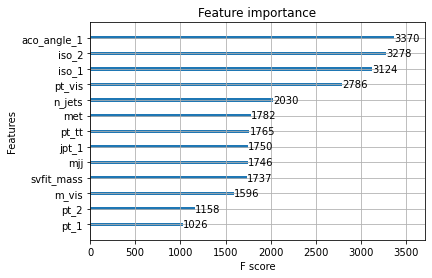

In [141]:
xgboost.plot_importance(xgb_clf_3).set_yticklabels(df_1.drop(['y','wt'], axis=1).columns)
# plt.savefig('./signal_background/feature_importance_weight.png')
plt.show()

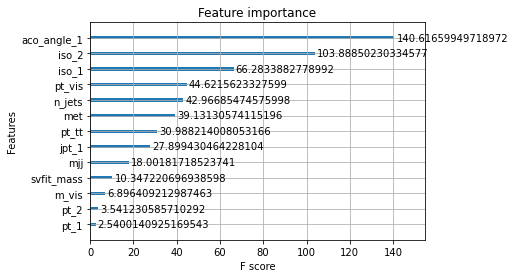

In [142]:
xgboost.plot_importance(xgb_clf_3, importance_type='gain').set_yticklabels(df_1.drop(['y','wt'], axis=1).columns)
# plt.savefig('./signal_background/feature_importance_gain.png')
plt.show()

ValueError: The number of FixedLocator locations (10), usually from a call to set_ticks, does not match the number of ticklabels (13).

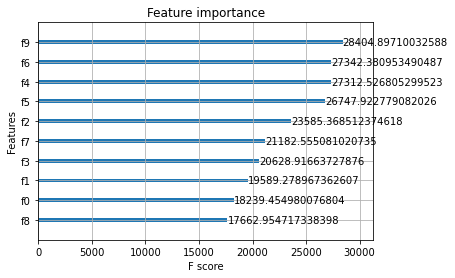

In [143]:
xgboost.plot_importance(xgb_clf, importance_type='cover').set_yticklabels(df_1.drop(['y','wt'], axis=1).columns)
# plt.savefig('./signal_background/eda/feature_importance.png')
plt.show()

In [110]:
y_pred = xgb_clf_3.predict_proba(X_test)

In [111]:
onehot=label_binarize(y_test,classes=[0,1,2,3])
fpr=dict()
tpr=dict()
thresh = dict()
roc_auc=dict()
for i in range(4):
    fpr[i], tpr[i], thresh[i] = roc_curve(onehot[:,i], y_pred[:,i])#,None,w_test)
    roc_auc[i] = auc(fpr[i], tpr[i])#,reorder=True)

In [153]:
write_auc('with_aco_angle_1', roc_auc)

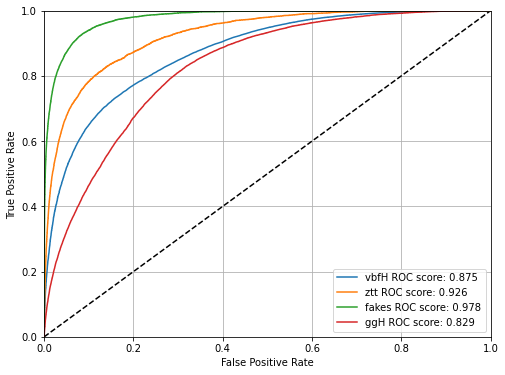

In [112]:
classes = ['vbfH', 'ztt', 'fakes', 'ggH']
fig, ax = plt.subplots(figsize=(8,6))
def plot_roc_curve(fpr, tpr, auc, i):
    ax.plot(fpr, tpr, label=f'{classes[i]} ROC score: {auc:.3f}')
    ax.set(xlabel='False Positive Rate', ylabel='True Positive Rate')
#     ax.text(0.6, 0.3, 'ROC AUC Score: {:.3f}'.format(auc),
#             bbox=dict(boxstyle='square,pad=0.3', fc='white', ec='k'))
    plt.legend()
lims = [np.min([ax.get_xlim(), ax.get_ylim()]), np.max([ax.get_xlim(), ax.get_ylim()])]
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.plot(lims, lims, 'k--')
ax.grid()
for i in range(len(fpr)):
    plot_roc_curve(fpr[i],tpr[i],roc_auc[i], i)
# plot_roc_curve(fpr[1],tpr[1],roc_auc[1], 1)
# plot_roc_curve(fpr[2],tpr[2],roc_auc[2], 2)
# plot_roc_curve(fpr[3],tpr[3],roc_auc[3], 3)
# plt.savefig('./signal_background/eda/roc_curves.png')

In [114]:
cr = classification_report(onehot, y_pred>0.5, output_dict=True, target_names=classes)
pd.DataFrame(cr).transpose()

/home/hep/shc3117/anaconda3/envs/msci/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
vbfH,0.809345,0.932242,0.866457,72685.0
ztt,0.837945,0.096451,0.172991,4396.0
fakes,0.790291,0.712932,0.749621,7284.0
ggH,0.647483,0.306745,0.416278,23143.0
micro avg,0.790818,0.748558,0.769108,107508.0
macro avg,0.771266,0.512093,0.551337,107508.0
weighted avg,0.774380,0.748558,0.733276,107508.0
samples avg,0.748558,0.748558,0.748558,107508.0


Normalised purity confusion matrix
[[0.81458783 0.24535    0.06262646 0.27997621]
 [0.00759911 0.46798744 0.02533541 0.01518672]
 [0.01036009 0.15480273 0.81788987 0.08792444]
 [0.16745297 0.13185983 0.09414826 0.61691262]]
Confusion matrix saved as /home/hep/shc3117/MSci-Project-HiggsTauTau/shared/signal_background/purity_with_aco_angle_1.png
Normalised efficiency confusion matrix
[[0.94862055 0.00160144 0.00636618 0.04341183]
 [0.52568074 0.18145255 0.15298675 0.13987996]
 [0.10982976 0.00919824 0.75686436 0.12410763]
 [0.64766055 0.00285849 0.03178583 0.31769513]]
Confusion matrix saved as /home/hep/shc3117/MSci-Project-HiggsTauTau/shared/signal_background/efficiency_with_aco_angle_1.png


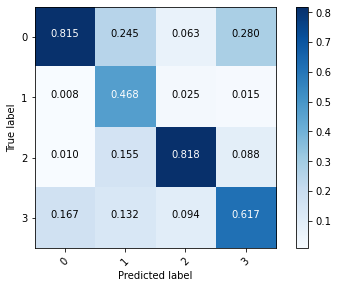

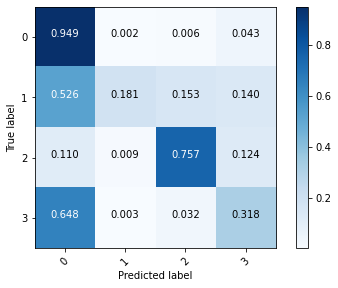

In [113]:
predict=xgb_clf_3.predict(X_test)
cm_p=plot_confusion_matrix(y_test, predict, [0,1,2,3],
                    normalise_by_row=True, w_test=w_test, figname=f'{write_path}purity_with_aco_angle_1.png')
cm_e=plot_confusion_matrix(y_test, predict, [0,1,2,3],
                    normalise_by_col=True, w_test=w_test, figname=f'{write_path}efficiency_with_aco_angle_1.png')

In [158]:
write_cm('with_aco_angle', cm_p, cm_e)

## looking at smote

oversampling
- SMOTE
- borderline SMOTE
- ADASYN  

oversampling and undersampling

- SMOTEENN
- SMOTETomek

In [36]:
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTEENN, SMOTETomek
from collections import Counter

In [72]:
df_1 = df.drop(selectors+['iso_1', 'iso_2'], axis=1)

In [73]:
df_1.drop(['y', 'wt'], axis=1).columns

Index(['pt_1', 'pt_2', 'm_vis', 'svfit_mass', 'mjj', 'jpt_1', 'pt_tt', 'met',
       'n_jets', 'pt_vis'],
      dtype='object')

In [74]:
X = df_1.drop(['y', 'wt'], axis=1).to_numpy()
y = df_1.y.astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=df_1.y)

In [40]:
print(sorted(Counter(y_test).items()))

[(0, 72685), (1, 4396), (2, 7284), (3, 23143)]


In [41]:
smote_enn = SMOTEENN(random_state=0)
# X_resampled, y_resampled = SMOTE().fit_resample(X_train, y_train)
X_resampled, y_resampled = smote_enn.fit_resample(X_train, y_train)

In [42]:
xgb_params = {
    "objective": "multi:softmax",
    "max_depth": 3,
    "learning_rate": 0.05,
    "silent": 1,
    "n_estimators": 1000,
    "subsample": 0.9,
    "seed": 123451,
}

xgb_clf_c = xgboost.XGBClassifier(**xgb_params)
# xgb_clf = xgboost.XGBClassifier()


In [43]:
eval_set = [(X_resampled, y_resampled), (X_test, y_test)]
xgb_clf_c.fit(X_resampled, y_resampled, verbose=2, early_stopping_rounds=50, eval_set=eval_set, eval_metric = "mlogloss")
# xgb_clf.fit(X_train, y_train, sample_weight=w_train, verbose=2, eval_metric="mlogloss")

/home/hep/shc3117/anaconda3/envs/msci/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:19:28] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-mlogloss:1.34390	validation_1-mlogloss:1.35728
[2]	validation_0-mlogloss:1.27001	validation_1-mlogloss:1.30767
[4]	validation_0-mlogloss:1.20708	validation_1-mlogloss:1.26636
[6]	validation_0-mlogloss:1.15283	validation_1-mlogloss:1.23150
[8]	validation_0-mlogloss:1.10581	validation_1-mlogloss:1.20220
[10]	validation_0-mlogloss:1.06466	validation_1-mlogloss:1.17736
[12]	validation_0-mlogloss:1.02788	validation_1-mlogloss:1.15630
[14]	validation_0-mlogloss:0.99479	validation_1-mlogloss:1.13754
[16]	validation_0-mlogloss:0.96548	validation_1-mlogloss:1.12148
[18]	validation_0-mlogloss:0.93911	validation_1-mlogloss:1.10764
[20]	validation_0-mlogloss:0.

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=16, num_parallel_tree=1,
              objective='multi:softprob', random_state=123451, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, seed=123451, silent=1,
              subsample=0.9, tree_method='exact', validate_parameters=1,
              verbosity=None)

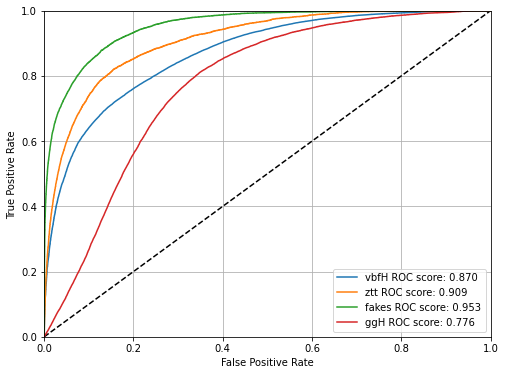

In [75]:
y_pred = xgb_clf_c.predict_proba(X_test)
onehot=label_binarize(y_test,classes=[0,1,2,3])
fpr=dict()
tpr=dict()
thresh = dict()
roc_auc=dict()
for i in range(4):
    fpr[i], tpr[i], thresh[i] = roc_curve(onehot[:,i], y_pred[:,i])#,None,w_test)
    roc_auc[i] = auc(fpr[i], tpr[i])#,reorder=True)
classes = ['vbfH', 'ztt', 'fakes', 'ggH']
fig, ax = plt.subplots(figsize=(8,6))
def plot_roc_curve(fpr, tpr, auc, i):
    ax.plot(fpr, tpr, label=f'{classes[i]} ROC score: {auc:.3f}')
    ax.set(xlabel='False Positive Rate', ylabel='True Positive Rate')
#     ax.text(0.6, 0.3, 'ROC AUC Score: {:.3f}'.format(auc),
#             bbox=dict(boxstyle='square,pad=0.3', fc='white', ec='k'))
    plt.legend()
lims = [np.min([ax.get_xlim(), ax.get_ylim()]), np.max([ax.get_xlim(), ax.get_ylim()])]
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.plot(lims, lims, 'k--')
ax.grid()
for i in range(len(fpr)):
    plot_roc_curve(fpr[i],tpr[i],roc_auc[i], i)
# plt.savefig('/signal_background/eda/roc_curves.png')

In [76]:
cr = classification_report(onehot, y_pred>0.5, output_dict=True)
pd.DataFrame(cr).transpose()

/home/hep/shc3117/anaconda3/envs/msci/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
0,0.935582,0.620830,0.746380,72685.0
1,0.310422,0.634895,0.416972,4396.0
2,0.644867,0.670099,0.657241,7284.0
3,0.434726,0.563756,0.490904,23143.0
micro avg,0.694528,0.612457,0.650915,107508.0
macro avg,0.581399,0.622395,0.577874,107508.0
weighted avg,0.782504,0.612457,0.671875,107508.0
samples avg,0.612457,0.612457,0.612457,107508.0


## removing m_vis

In [215]:
df_1 = df.drop(selectors+['iso_1', 'iso_2', 'm_vis', 'aco_angle_1'], axis=1)

In [193]:
# xgb_params = {
#     "objective": "multi:softmax",
#     "max_depth": 6,
#     "num_classes": 4,
# }
xgb_params = {
    "objective": "multi:softprob",
    "max_depth": 3,
    "learning_rate": 0.05,
    "silent": 1,
    "n_estimators": 1000,
    "subsample": 0.9,
    "seed": 123451,
}

xgb_clf_test = xgboost.XGBClassifier(**xgb_params)
# xgb_clf = xgboost.XGBClassifier()


In [194]:
df_1.drop(['y', 'wt'], axis=1).columns

Index(['pt_1', 'pt_2', 'svfit_mass', 'mjj', 'jpt_1', 'pt_tt', 'met', 'n_jets',
       'pt_vis'],
      dtype='object')

In [218]:
X = df_1.drop(['y', 'wt'], axis=1).to_numpy()
y = df_1.y.astype(int)
w = df_1.wt
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X, y, w, test_size=0.2, random_state=1, stratify=df_1.y)

In [196]:
eval_set = [(X_train, y_train), (X_test, y_test)]
xgb_clf_test.fit(X_train, y_train, sample_weight=w_train, verbose=2, early_stopping_rounds=50, eval_set=eval_set, eval_metric = "mlogloss")
# xgb_clf.fit(X_train, y_train, sample_weight=w_train, verbose=2, eval_metric="mlogloss")

/home/hep/shc3117/anaconda3/envs/msci/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:09:57] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-mlogloss:1.33436	validation_1-mlogloss:1.33422
[2]	validation_0-mlogloss:1.24440	validation_1-mlogloss:1.24409
[4]	validation_0-mlogloss:1.16898	validation_1-mlogloss:1.16854
[6]	validation_0-mlogloss:1.10471	validation_1-mlogloss:1.10430
[8]	validation_0-mlogloss:1.04935	validation_1-mlogloss:1.04887
[10]	validation_0-mlogloss:1.00141	validation_1-mlogloss:1.00082
[12]	validation_0-mlogloss:0.95973	validation_1-mlogloss:0.95919
[14]	validation_0-mlogloss:0.92312	validation_1-mlogloss:0.92258
[16]	validation_0-mlogloss:0.89074	validation_1-mlogloss:0.89018
[18]	validation_0-mlogloss:0.86218	validation_1-mlogloss:0.86158
[20]	validation_0-mlogloss:0.

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=16, num_parallel_tree=1,
              objective='multi:softprob', random_state=123451, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, seed=123451, silent=1,
              subsample=0.9, tree_method='exact', validate_parameters=1,
              verbosity=None)

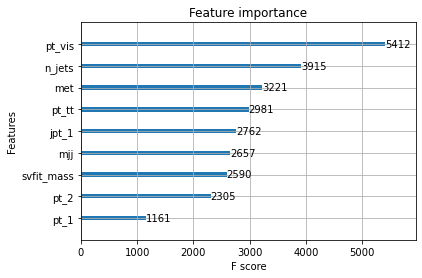

In [216]:
xgboost.plot_importance(xgb_clf_test).set_yticklabels(df_1.drop(['y','wt'], axis=1).columns)
plt.savefig('./signal_background/feature_importance_weight_without_m_vis.png')
plt.show()

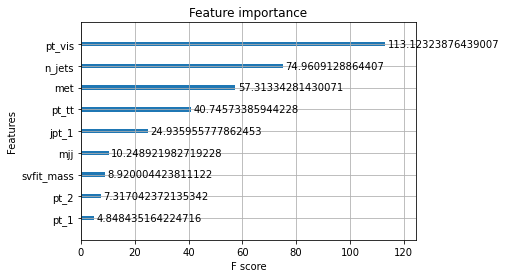

In [199]:
xgboost.plot_importance(xgb_clf_test, importance_type='gain').set_yticklabels(df_1.drop(['y','wt'], axis=1).columns)
plt.savefig('./signal_background/feature_importance_gain_without_m_vis.png.png')
plt.show()

In [219]:
y_pred = xgb_clf_test.predict_proba(X_test)

In [220]:
onehot=label_binarize(y_test,classes=[0,1,2,3])
fpr=dict()
tpr=dict()
thresh = dict()
roc_auc=dict()
for i in range(4):
    fpr[i], tpr[i], thresh[i] = roc_curve(onehot[:,i], y_pred[:,i])#,None,w_test)
    roc_auc[i] = auc(fpr[i], tpr[i])#,reorder=True)

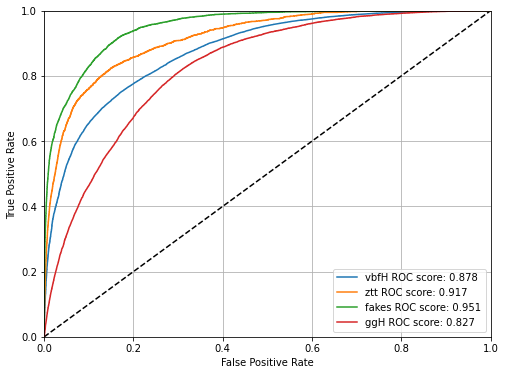

In [221]:
classes = ['vbfH', 'ztt', 'fakes', 'ggH']
fig, ax = plt.subplots(figsize=(8,6))
def plot_roc_curve(fpr, tpr, auc, i):
    ax.plot(fpr, tpr, label=f'{classes[i]} ROC score: {auc:.3f}')
    ax.set(xlabel='False Positive Rate', ylabel='True Positive Rate')
#     ax.text(0.6, 0.3, 'ROC AUC Score: {:.3f}'.format(auc),
#             bbox=dict(boxstyle='square,pad=0.3', fc='white', ec='k'))
    plt.legend()
lims = [np.min([ax.get_xlim(), ax.get_ylim()]), np.max([ax.get_xlim(), ax.get_ylim()])]
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.plot(lims, lims, 'k--')
ax.grid()
for i in range(len(fpr)):
    plot_roc_curve(fpr[i],tpr[i],roc_auc[i], i)
# plot_roc_curve(fpr[1],tpr[1],roc_auc[1], 1)
# plot_roc_curve(fpr[2],tpr[2],roc_auc[2], 2)
# plot_roc_curve(fpr[3],tpr[3],roc_auc[3], 3)
# plt.savefig('/signal_background/eda/roc_curves.png')